# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.00152378, -0.21819714, -0.0208793 ,  0.23718299]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.418835081159701 -2.8543580202334966


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, reward, float(done)])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([ 0.03145038, -0.38521736, -0.03503782,  0.53091768]), 1.0, 0)

In [19]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, reward, done])
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            dones = np.array([each[3] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
    
            # Updating the model using NEW memory and targetQs/nextQs
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 Total reward: 15.0 Average loss: 0.676845670 Explore P: 0.998516113
Episode: 1 Total reward: 28.0 Average loss: 0.554229081 Explore P: 0.995752139
Episode: 2 Total reward: 23.0 Average loss: 0.367771119 Explore P: 0.993487515
Episode: 3 Total reward: 21.0 Average loss: 0.230338737 Explore P: 0.991424358
Episode: 4 Total reward: 42.0 Average loss: 0.279758126 Explore P: 0.987311020
Episode: 5 Total reward: 17.0 Average loss: 0.298013061 Explore P: 0.985651003
Episode: 6 Total reward: 35.0 Average loss: 0.337837696 Explore P: 0.982242193
Episode: 7 Total reward: 15.0 Average loss: 0.357411236 Explore P: 0.980784923
Episode: 8 Total reward: 15.0 Average loss: 0.331737995 Explore P: 0.979329837
Episode: 9 Total reward: 23.0 Average loss: 0.355731189 Explore P: 0.977102940
Episode: 10 Total reward: 25.0 Average loss: 0.345459104 Explore P: 0.974688203
Episode: 11 Total reward: 37.0 Average loss: 0.342513412 Explore P: 0.971125452
Episode: 12 Total reward: 17.0 Average loss: 0.302

Episode: 104 Total reward: 43.0 Average loss: 0.114061013 Explore P: 0.746275922
Episode: 105 Total reward: 31.0 Average loss: 0.102536336 Explore P: 0.743997001
Episode: 106 Total reward: 19.0 Average loss: 0.129172146 Explore P: 0.742603731
Episode: 107 Total reward: 20.0 Average loss: 0.157476932 Explore P: 0.741139988
Episode: 108 Total reward: 87.0 Average loss: 0.103074796 Explore P: 0.734806660
Episode: 109 Total reward: 32.0 Average loss: 0.086037442 Explore P: 0.732490986
Episode: 110 Total reward: 16.0 Average loss: 0.077423126 Explore P: 0.731335924
Episode: 111 Total reward: 78.0 Average loss: 0.079061255 Explore P: 0.725731390
Episode: 112 Total reward: 33.0 Average loss: 0.074385226 Explore P: 0.723373369
Episode: 113 Total reward: 13.0 Average loss: 0.076709740 Explore P: 0.722446587
Episode: 114 Total reward: 21.0 Average loss: 0.081453778 Explore P: 0.720952019
Episode: 115 Total reward: 12.0 Average loss: 0.084680289 Explore P: 0.720099388
Episode: 116 Total reward: 1

Episode: 205 Total reward: 55.0 Average loss: 0.043068275 Explore P: 0.444156446
Episode: 206 Total reward: 187.0 Average loss: 0.030038232 Explore P: 0.436113159
Episode: 207 Total reward: 143.0 Average loss: 0.023169594 Explore P: 0.430063102
Episode: 208 Total reward: 150.0 Average loss: 0.024142770 Explore P: 0.423809177
Episode: 209 Total reward: 200.0 Average loss: 0.010368555 Explore P: 0.415615207
Episode: 210 Total reward: 77.0 Average loss: 0.021471279 Explore P: 0.412503963
Episode: 211 Total reward: 200.0 Average loss: 0.024764635 Explore P: 0.404533851
Episode: 212 Total reward: 168.0 Average loss: 0.032108869 Explore P: 0.397961048
Episode: 213 Total reward: 17.0 Average loss: 0.067544408 Explore P: 0.397302075
Episode: 214 Total reward: 95.0 Average loss: 0.058036163 Explore P: 0.393640127
Episode: 215 Total reward: 69.0 Average loss: 0.019347431 Explore P: 0.391002121
Episode: 216 Total reward: 19.0 Average loss: 0.023975547 Explore P: 0.390278905
Episode: 217 Total rew

Episode: 306 Total reward: 118.0 Average loss: 0.693147004 Explore P: 0.197467396
Episode: 307 Total reward: 66.0 Average loss: 0.693147063 Explore P: 0.196234185
Episode: 308 Total reward: 87.0 Average loss: 0.693147004 Explore P: 0.194620976
Episode: 309 Total reward: 82.0 Average loss: 0.693147123 Explore P: 0.193113274
Episode: 310 Total reward: 39.0 Average loss: 0.693147242 Explore P: 0.192400523
Episode: 311 Total reward: 88.0 Average loss: 0.693147123 Explore P: 0.190802440
Episode: 312 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.189128772
Episode: 313 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.187435106
Episode: 314 Total reward: 85.0 Average loss: 0.693147063 Explore P: 0.185933300
Episode: 315 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.184269847
Episode: 316 Total reward: 84.0 Average loss: 0.693147063 Explore P: 0.182812111
Episode: 317 Total reward: 74.0 Average loss: 0.693147063 Explore P: 0.181538022
Episode: 318 Total reward: 

Episode: 407 Total reward: 102.0 Average loss: 0.693147004 Explore P: 0.086096703
Episode: 408 Total reward: 89.0 Average loss: 0.693147123 Explore P: 0.085422448
Episode: 409 Total reward: 111.0 Average loss: 0.693147004 Explore P: 0.084589888
Episode: 410 Total reward: 98.0 Average loss: 0.693147063 Explore P: 0.083862477
Episode: 411 Total reward: 97.0 Average loss: 0.693147063 Explore P: 0.083149474
Episode: 412 Total reward: 113.0 Average loss: 0.693147063 Explore P: 0.082327538
Episode: 413 Total reward: 81.0 Average loss: 0.693147123 Explore P: 0.081744051
Episode: 414 Total reward: 103.0 Average loss: 0.693147004 Explore P: 0.081008880
Episode: 415 Total reward: 109.0 Average loss: 0.693147004 Explore P: 0.080239086
Episode: 416 Total reward: 102.0 Average loss: 0.693147004 Explore P: 0.079526289
Episode: 417 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.078868917
Episode: 418 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.078231405
Episode: 419 Total rew

Episode: 508 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.038335203
Episode: 509 Total reward: 101.0 Average loss: 0.693147063 Explore P: 0.038050458
Episode: 510 Total reward: 94.0 Average loss: 0.693147063 Explore P: 0.037788019
Episode: 511 Total reward: 102.0 Average loss: 0.693147004 Explore P: 0.037506021
Episode: 512 Total reward: 100.0 Average loss: 0.693147063 Explore P: 0.037232332
Episode: 513 Total reward: 104.0 Average loss: 0.693147063 Explore P: 0.036950583
Episode: 514 Total reward: 90.0 Average loss: 0.693147123 Explore P: 0.036709116
Episode: 515 Total reward: 100.0 Average loss: 0.693147063 Explore P: 0.036443356
Episode: 516 Total reward: 99.0 Average loss: 0.693147063 Explore P: 0.036182859
Episode: 517 Total reward: 80.0 Average loss: 0.693147123 Explore P: 0.035974231
Episode: 518 Total reward: 92.0 Average loss: 0.693147063 Explore P: 0.035736364
Episode: 519 Total reward: 94.0 Average loss: 0.693147063 Explore P: 0.035495576
Episode: 520 Total rewa

Episode: 609 Total reward: 96.0 Average loss: 0.693147123 Explore P: 0.020761823
Episode: 610 Total reward: 97.0 Average loss: 0.693147063 Explore P: 0.020657938
Episode: 611 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.020561390
Episode: 612 Total reward: 87.0 Average loss: 0.693147004 Explore P: 0.020469905
Episode: 613 Total reward: 103.0 Average loss: 0.693147004 Explore P: 0.020362618
Episode: 614 Total reward: 114.0 Average loss: 0.693147004 Explore P: 0.020245155
Episode: 615 Total reward: 84.0 Average loss: 0.693147063 Explore P: 0.020159456
Episode: 616 Total reward: 105.0 Average loss: 0.693147063 Explore P: 0.020053340
Episode: 617 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.019960278
Episode: 618 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.019866103
Episode: 619 Total reward: 101.0 Average loss: 0.693147063 Explore P: 0.019766957
Episode: 620 Total reward: 84.0 Average loss: 0.693147063 Explore P: 0.019685258
Episode: 621 Total rewar

Episode: 710 Total reward: 101.0 Average loss: 0.693147063 Explore P: 0.014023310
Episode: 711 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.013986864
Episode: 712 Total reward: 105.0 Average loss: 0.693147063 Explore P: 0.013945221
Episode: 713 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.013907919
Episode: 714 Total reward: 94.0 Average loss: 0.693147063 Explore P: 0.013871356
Episode: 715 Total reward: 117.0 Average loss: 0.693147004 Explore P: 0.013826325
Episode: 716 Total reward: 114.0 Average loss: 0.693147004 Explore P: 0.013782953
Episode: 717 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.013748684
Episode: 718 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.013713983
Episode: 719 Total reward: 81.0 Average loss: 0.693147123 Explore P: 0.013684021
Episode: 720 Total reward: 99.0 Average loss: 0.693147063 Explore P: 0.013647730
Episode: 721 Total reward: 82.0 Average loss: 0.693147123 Explore P: 0.013617941
Episode: 722 Total rewar

Episode: 811 Total reward: 99.0 Average loss: 0.693147063 Explore P: 0.011506524
Episode: 812 Total reward: 97.0 Average loss: 0.693147063 Explore P: 0.011491981
Episode: 813 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.011478466
Episode: 814 Total reward: 86.0 Average loss: 0.693147063 Explore P: 0.011465806
Episode: 815 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.011452527
Episode: 816 Total reward: 110.0 Average loss: 0.693147004 Explore P: 0.011436637
Episode: 817 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.011423338
Episode: 818 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.011410162
Episode: 819 Total reward: 108.0 Average loss: 0.693147004 Explore P: 0.011395015
Episode: 820 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.011381825
Episode: 821 Total reward: 104.0 Average loss: 0.693147063 Explore P: 0.011367528
Episode: 822 Total reward: 108.0 Average loss: 0.693147004 Explore P: 0.011352838
Episode: 823 Total rewar

Episode: 912 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.010557945
Episode: 913 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.010552670
Episode: 914 Total reward: 93.0 Average loss: 0.693147063 Explore P: 0.010547554
Episode: 915 Total reward: 101.0 Average loss: 0.693147063 Explore P: 0.010542051
Episode: 916 Total reward: 107.0 Average loss: 0.693147063 Explore P: 0.010536282
Episode: 917 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.010531211
Episode: 918 Total reward: 101.0 Average loss: 0.693147063 Explore P: 0.010525873
Episode: 919 Total reward: 110.0 Average loss: 0.693147004 Explore P: 0.010520120
Episode: 920 Total reward: 95.0 Average loss: 0.693147063 Explore P: 0.010515203
Episode: 921 Total reward: 105.0 Average loss: 0.693147063 Explore P: 0.010509821
Episode: 922 Total reward: 104.0 Average loss: 0.693147063 Explore P: 0.010504547
Episode: 923 Total reward: 91.0 Average loss: 0.693147123 Explore P: 0.010499976
Episode: 924 Total rew

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

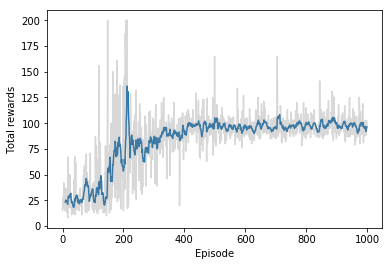

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

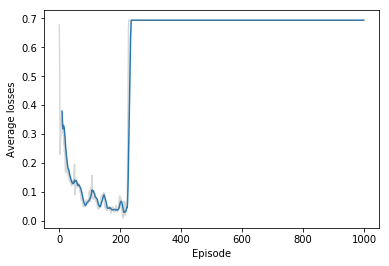

In [26]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
import gym
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        
        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
    # Closing the env
    print('total reward: {:.1f}'.format(total_reward))
    env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total reward: 289.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.